In [1]:
import tensorflow as tf

# Pastikan menggunakan session dengan benar jika menggunakan TensorFlow 1.x
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


### Import libs

In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


#### Config setting

In [3]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 300

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [4]:
def get_data(input_path):
    found_bg = False
    all_imgs = {}
    classes_count = {}
    class_mapping = {}
    i = 1

    with open(input_path, 'r') as f:
        print('Parsing annotation files')
        for line in f:
            sys.stdout.write('\r' + 'idx=' + str(i))
            i += 1
            line_split = line.strip().split(',')
            (filename, x1, y1, x2, y2, class_name) = line_split

            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                if class_name == 'bg' and not found_bg:
                    print('Found bg class, setting as background.')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            if filename not in all_imgs:
                all_imgs[filename] = {}
                img = cv2.imread(filename)
                (rows, cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []

            all_imgs[filename]['bboxes'].append({
                'class': class_name, 'x1': int(x1), 'y1': int(y1), 'x2': int(x2), 'y2': int(y2)
            })

    return list(all_imgs.values()), classes_count, class_mapping


In [5]:
all_imgs, classes_count, class_mapping = get_data("C:/Users/Lenovo/Documents/TA-2025-01/train annotation_normalized4.txt")

# Debugging untuk memastikan class_mapping tetap benar
print(" Isi class_mapping sebelum digunakan:", class_mapping)


Parsing annotation files
idx=1759 Isi class_mapping sebelum digunakan: {'Mobil': 0}


#### Define ROI Pooling Convolutional Layer

In [6]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer # Keep this import for Keras standalone Layer

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):
        # --- MODIFIKASI DIMULAI DI SINI ---
        # Hapus baris yang menyebabkan AttributeError:
        # self.dim_ordering = K.image_dim_ordering()

        # Tetapkan dim_ordering secara eksplisit ke 'channels_last'.
        # Ini adalah format standar di Keras/TensorFlow modern dan cocok dengan K.image_data_format() Anda.
        self.dim_ordering = 'channels_last'
        # --- MODIFIKASI BERAKHIR DI SINI ---

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        # 'channels_last' berarti dimensi channel adalah yang terakhir (indeks 3)
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        # Output shape ini (batch, num_rois, pool_size, pool_size, channels)
        # sudah dalam format 'channels_last', jadi tidak perlu perubahan.
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        # input_shape = K.shape(img) # Baris ini tidak langsung digunakan untuk indexing di bawah

        outputs = []

        for roi_idx in range(self.num_rois):
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # --- MODIFIKASI DIMULAI DI SINI ---
            # tf.image.resize_images telah diganti namanya di TF2.x menjadi tf.image.resize.
            # Meskipun Anda menggunakan TF 1.15, fungsi ini lebih konsisten dan aman.
            cropped_img = img[:, y:y+h, x:x+w, :]
            rs = tf.image.resize(cropped_img, (self.pool_size, self.pool_size))
            # --- MODIFIKASI BERAKHIR DI SINI ---

            outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Ini sudah benar untuk 'channels_last'.
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # K.permute_dimensions(final_output, (0, 1, 2, 3, 4)) tidak mengubah urutan dimensi.
        # Anda bisa mempertahankannya jika ingin eksplisit, atau menghapusnya jika tidak ada efek.
        # Jika Anda ingin output channels-first (..., channels, height, width), Anda akan menggunakan (0, 1, 4, 2, 3).
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output

    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Vgg-16 model

In [7]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

####  RPN layer

In [8]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

####  Classifier layer

In [9]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

#### Calculate IoU (Intersection of Union)

In [10]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [11]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### Get new image size and augment the image

In [12]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [13]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

In [14]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
	# if there are no boxes, return an empty list
  
    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
	if len(boxes) == 0:
		return []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# calculate the areas
	area = (x2 - x1) * (y2 - y1)

	# sort the bounding boxes 
	idxs = np.argsort(probs)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the intersection

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		# find the union
		area_union = area[i] + area[idxs[:last]] - area_int

		# compute the ratio of overlap
		overlap = area_int/(area_union + 1e-6)

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	# return only the bounding boxes that were picked using the integer data type
	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

def apply_regr_np(X, T):
	"""Apply regression layer to all anchors in one feature map

	Args:
		X: shape=(4, 18, 25) the current anchor type for all points in the feature map
		T: regression layer shape=(4, 18, 25)

	Returns:
		X: regressed position and size for current anchor
	"""
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

In [15]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 9) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 36) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 9) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [16]:
def compute_precision_recall(gt_boxes, pred_boxes, scores, iou_threshold=0.5):
    pred_boxes = np.array(pred_boxes)
    scores = np.array(scores)
    gt_boxes = np.array(gt_boxes)

    sorted_indices = np.argsort(scores)[::-1]
    pred_boxes = pred_boxes[sorted_indices]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched = np.zeros(len(gt_boxes))

    for i, pred_box in enumerate(pred_boxes):
        max_iou = 0
        max_gt_idx = -1
        for j, gt_box in enumerate(gt_boxes):
            current_iou = iou(pred_box, gt_box)
            if current_iou > max_iou:
                max_iou = current_iou
                max_gt_idx = j

        if max_iou >= iou_threshold and matched[max_gt_idx] == 0:
            tp[i] = 1
            matched[max_gt_idx] = 1
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    precision = cum_tp / (cum_tp + cum_fp + 1e-6)
    recall = cum_tp / (len(gt_boxes) + 1e-6)

    return precision, recall




---





---



In [17]:
base_path = 'C:/Users/Lenovo/Documents/TA-2025-01'

test_path = 'C:/Users/Lenovo/Documents/TA-2025-01/train annotation_normalized3.txt' # Test data (annotation file)

test_base_path = 'C:/Users/Lenovo/Documents/TA-2025-01/Image_Test' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [18]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

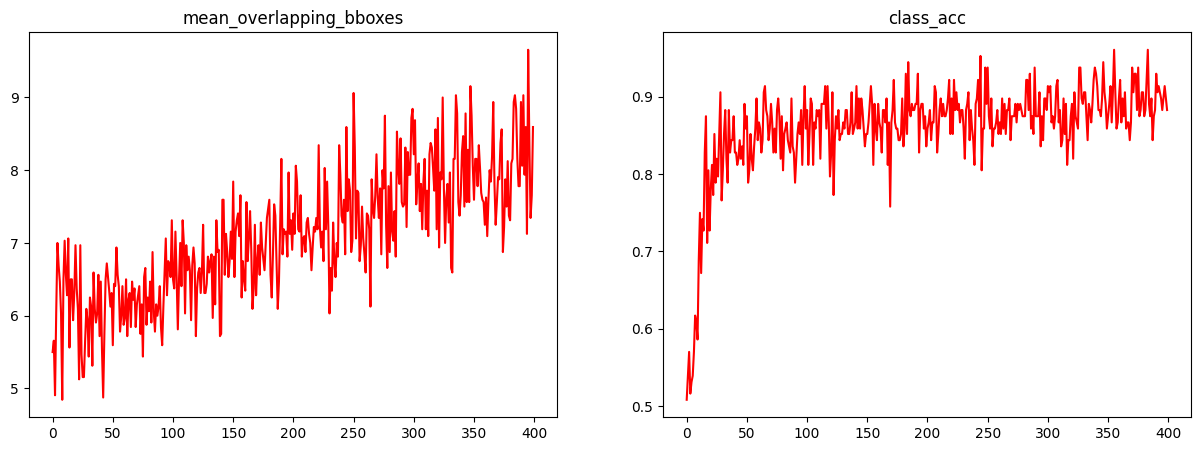

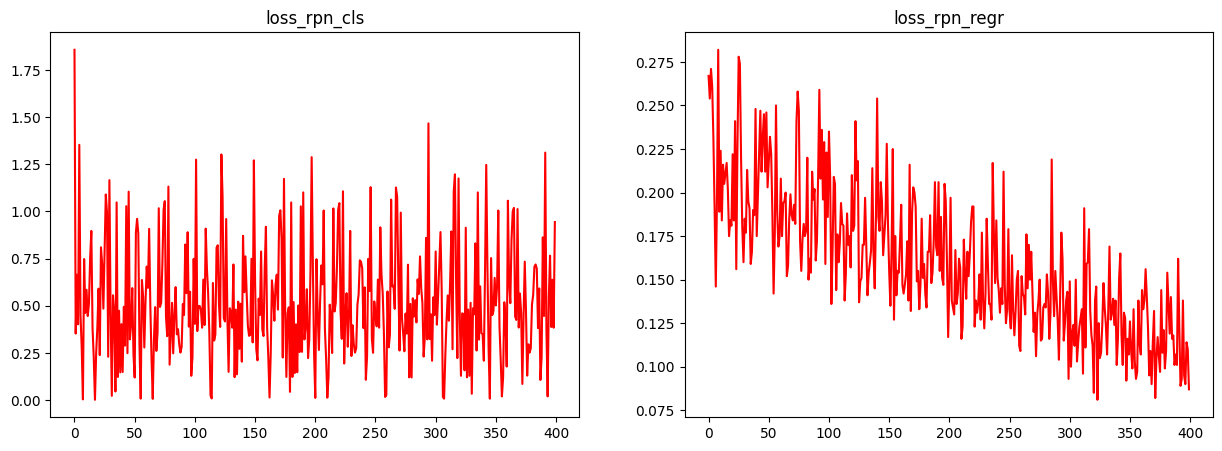

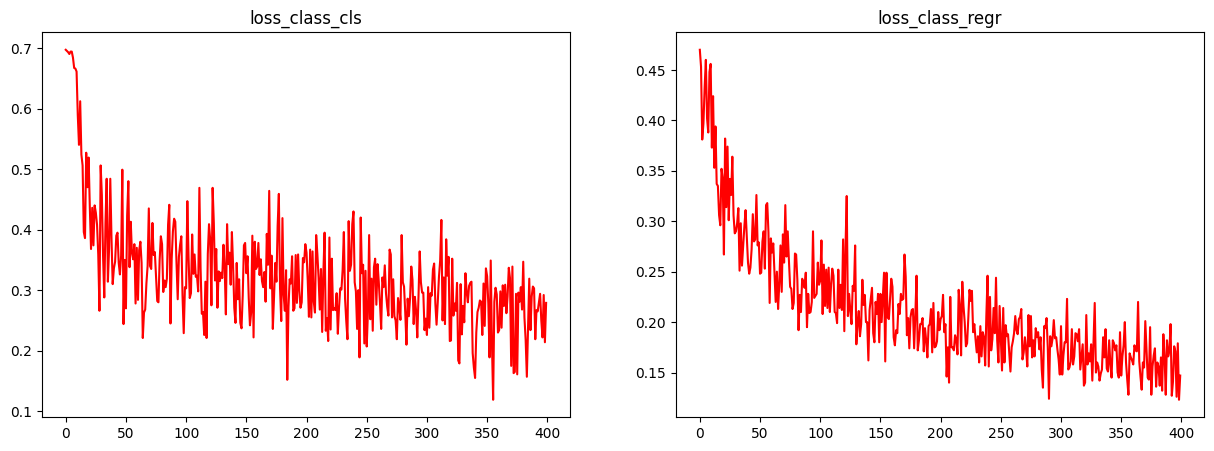

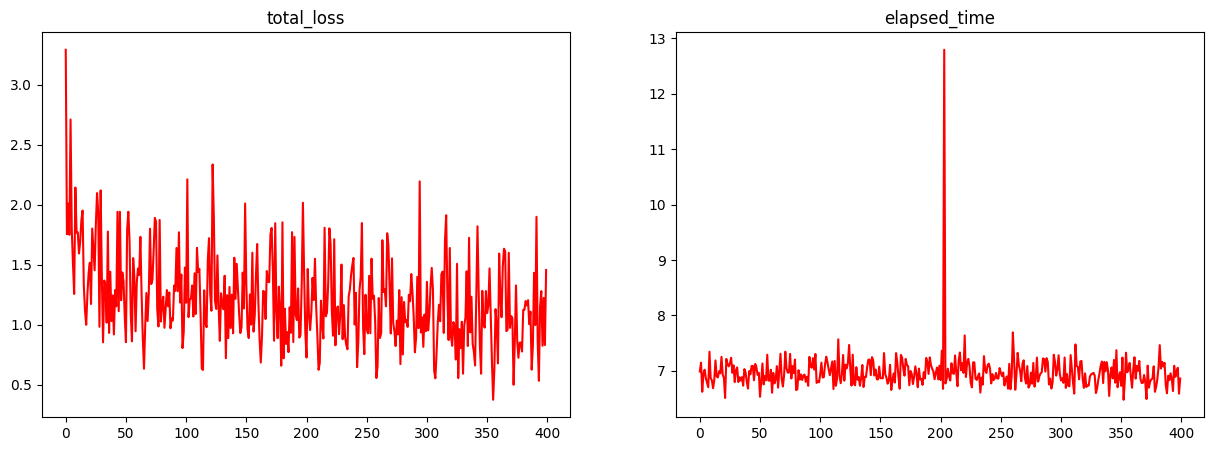

In [19]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

In [20]:
import keras.backend as K

# Set learning phase to 0 (inference mode)
K.set_learning_phase(0)

# Test

In [21]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [22]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')





Loading weights from model_frcnn_vgg.hdf5









In [23]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Mobil', 1: 'bg'}


In [24]:
test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

00de3a8c327e4ac5b5aea13040b4c449_jpg.rf.aa68af9486b464cdc73af7b38d201165.jpg
Elapsed time = 5.975328207015991
[('Mobil', 99.94663596153259)]


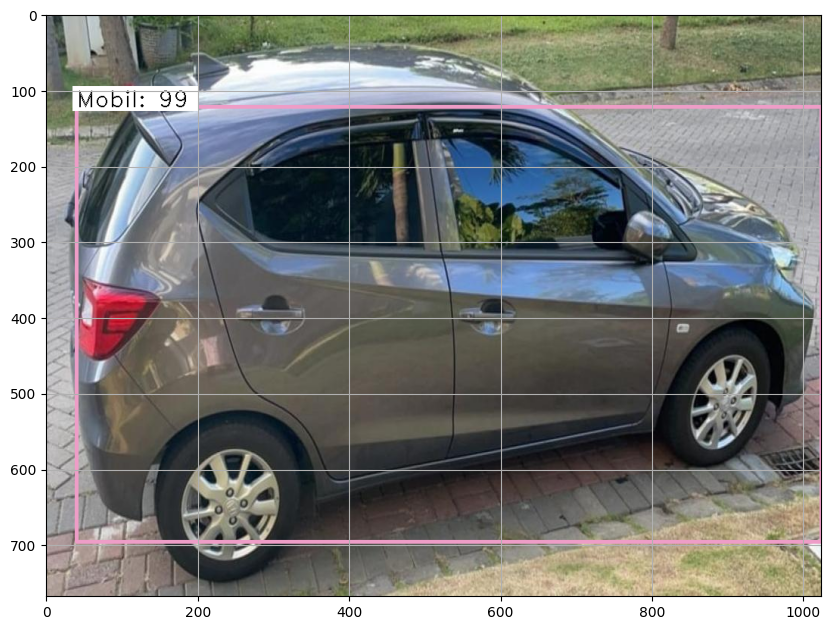

00dacc1743fa439bac871610f8a9a333_jpg.rf.14e733b00f4770614eb69ee34cdae683.jpg
Elapsed time = 6.165652275085449
[('Mobil', 99.97887015342712), ('Mobil', 88.33221197128296)]


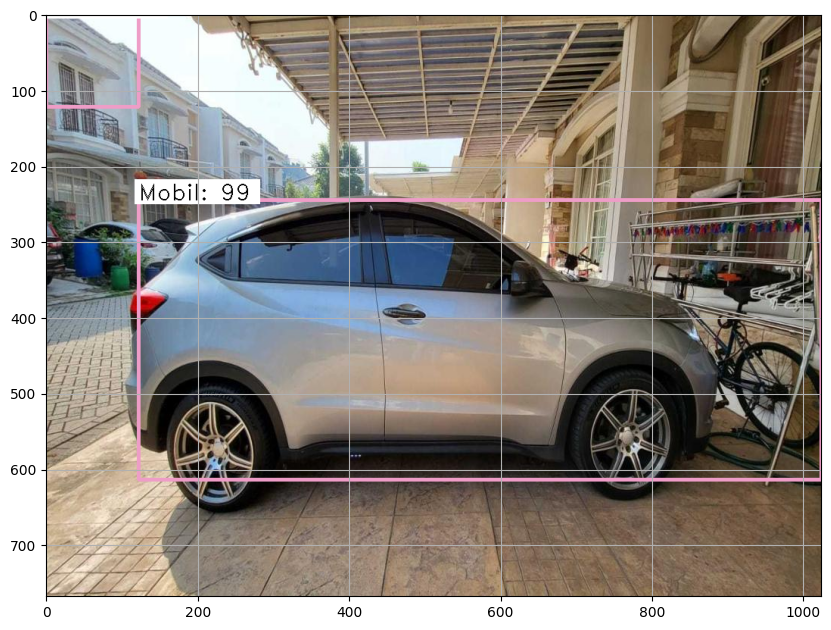

img.jpg
Elapsed time = 6.137155294418335
[('Mobil', 98.23377132415771)]


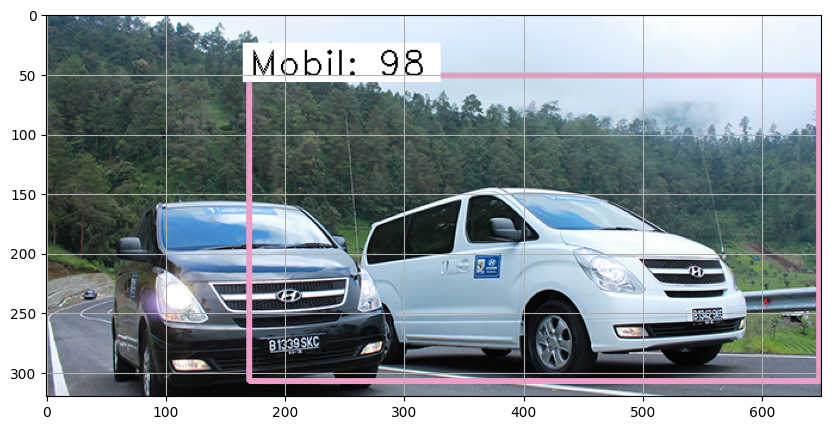

00db5e54991641fca9d430e7ae47af85_jpg.rf.22047dddec4af574eb696e39f418db42.jpg
Elapsed time = 5.120264291763306
[('Mobil', 99.6188223361969), ('Mobil', 91.51783585548401)]


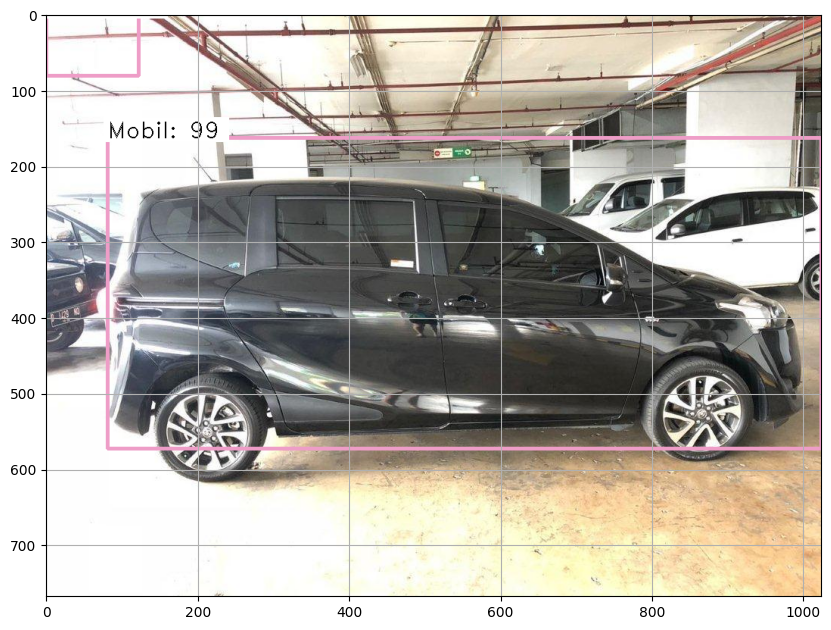

img4.jpg
Elapsed time = 5.612586498260498
[('Mobil', 99.72401857376099), ('Mobil', 87.62475848197937), ('Mobil', 86.90595626831055), ('Mobil', 85.50302982330322)]


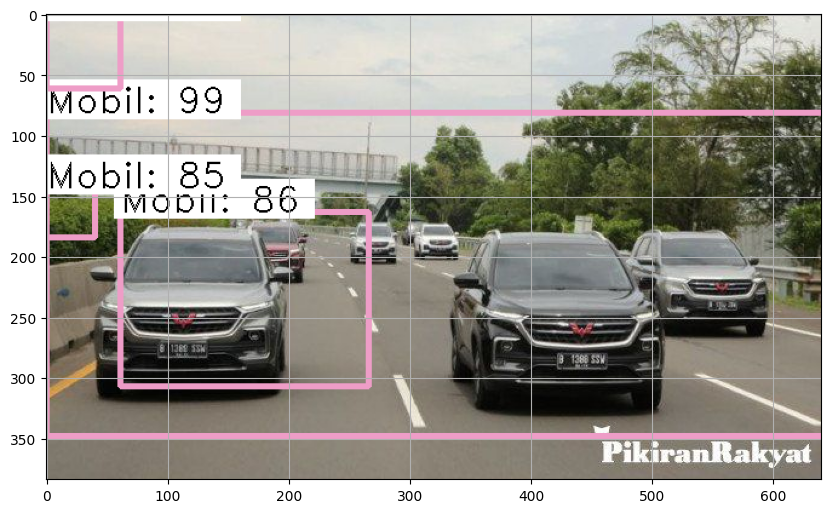

00db5e54991641fca9d430e7ae47af85_jpg.rf.22047dddec4af574eb696e39f418db42.jpg
Elapsed time = 4.824223518371582
[('Mobil', 99.6188223361969), ('Mobil', 91.51783585548401)]


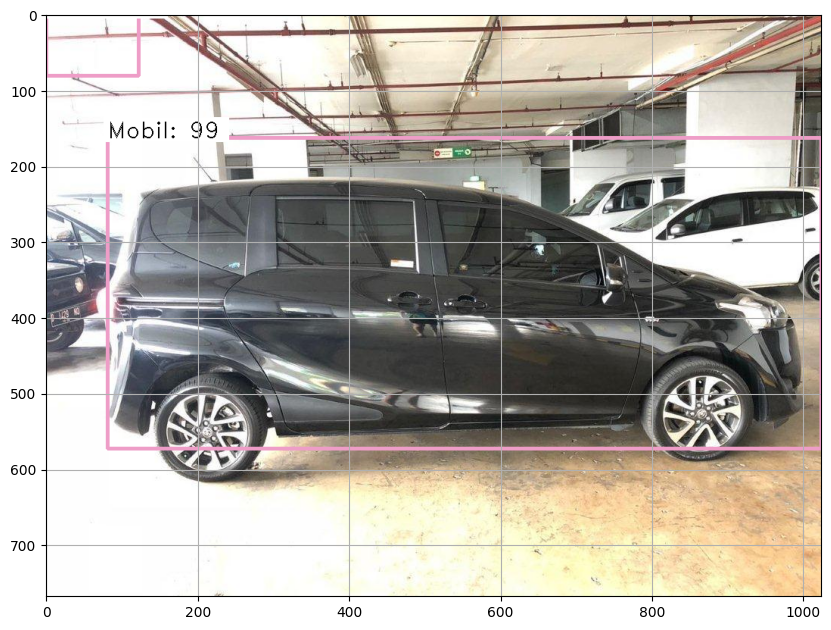

img4.jpg
Elapsed time = 5.183492660522461
[('Mobil', 99.72401857376099), ('Mobil', 87.62475848197937), ('Mobil', 86.90595626831055), ('Mobil', 85.50302982330322)]


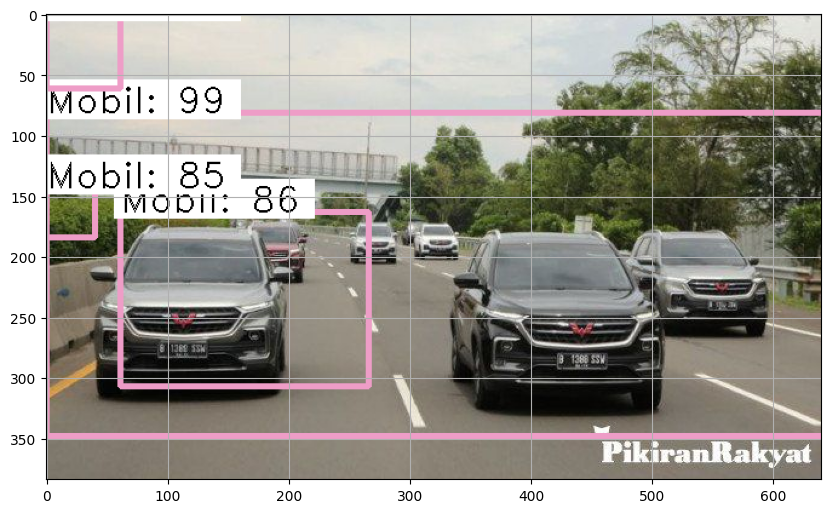

00db5e54991641fca9d430e7ae47af85_jpg.rf.22047dddec4af574eb696e39f418db42.jpg
Elapsed time = 4.7937891483306885
[('Mobil', 99.6188223361969), ('Mobil', 91.51783585548401)]


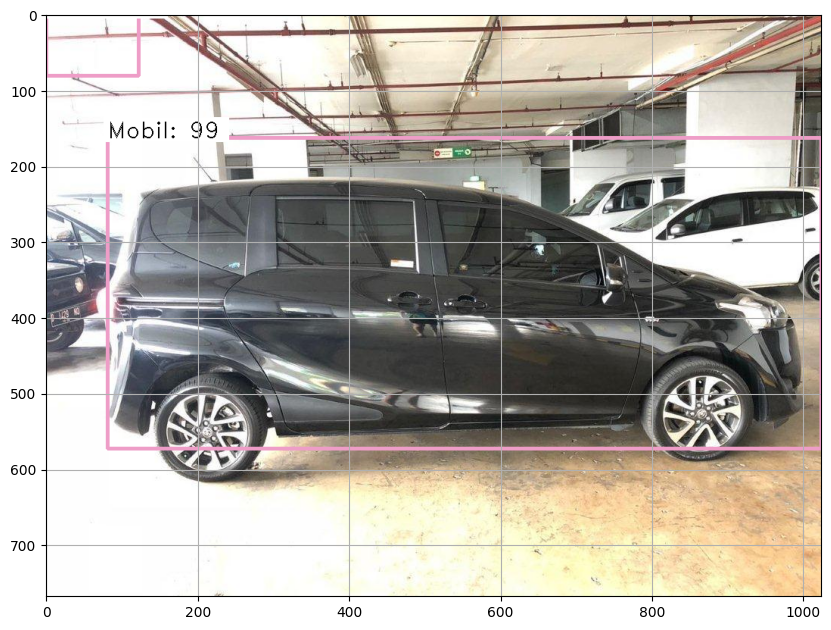

img2.jpg
Elapsed time = 4.993180513381958
[('Mobil', 99.90297555923462)]


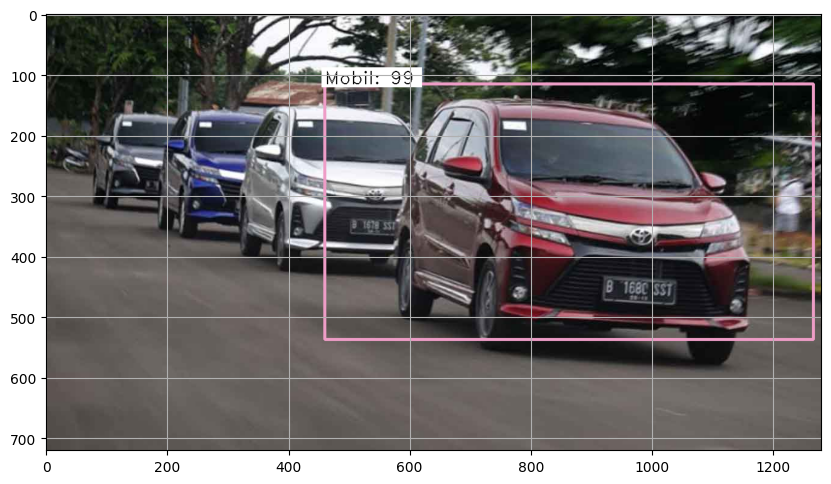

00dacc1743fa439bac871610f8a9a333_jpg.rf.14e733b00f4770614eb69ee34cdae683.jpg
Elapsed time = 4.488102436065674
[('Mobil', 99.97887015342712), ('Mobil', 88.33221197128296)]


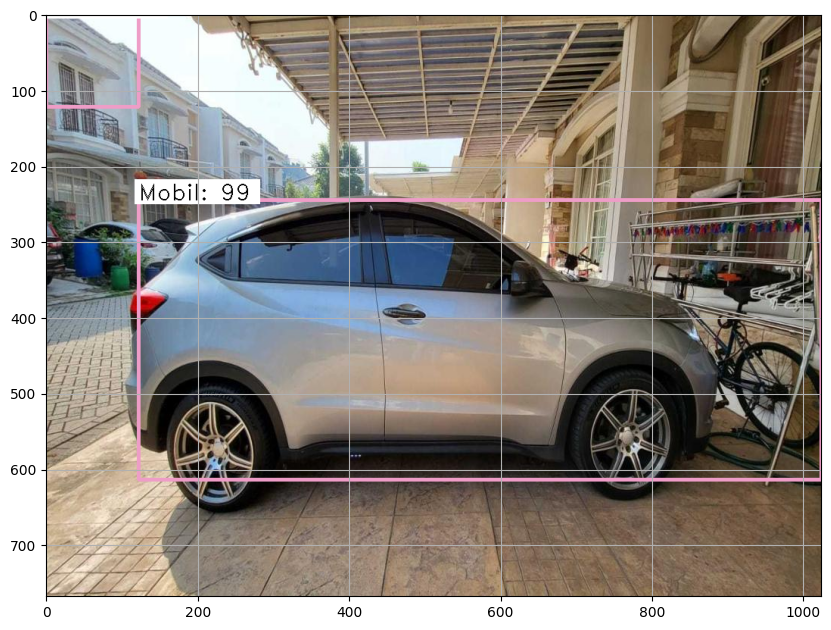

img2.jpg
Elapsed time = 4.913636922836304
[('Mobil', 99.90297555923462)]


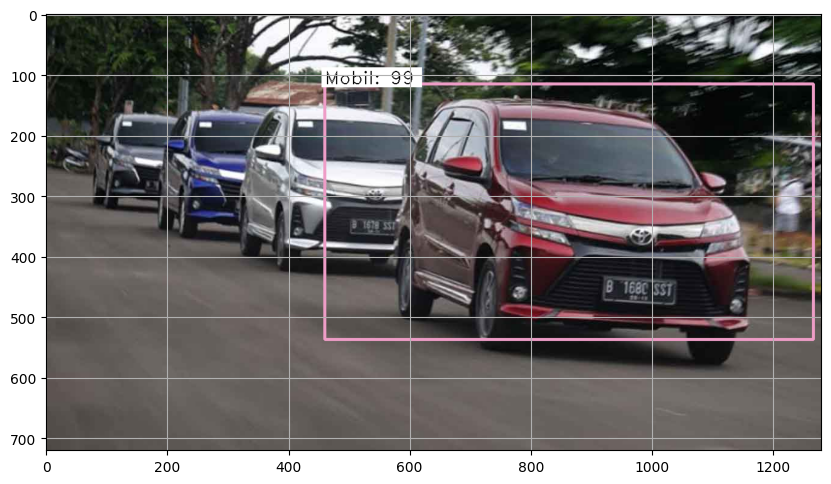

img4.jpg
Elapsed time = 4.8797571659088135
[('Mobil', 99.72401857376099), ('Mobil', 87.62475848197937), ('Mobil', 86.90595626831055), ('Mobil', 85.50302982330322)]


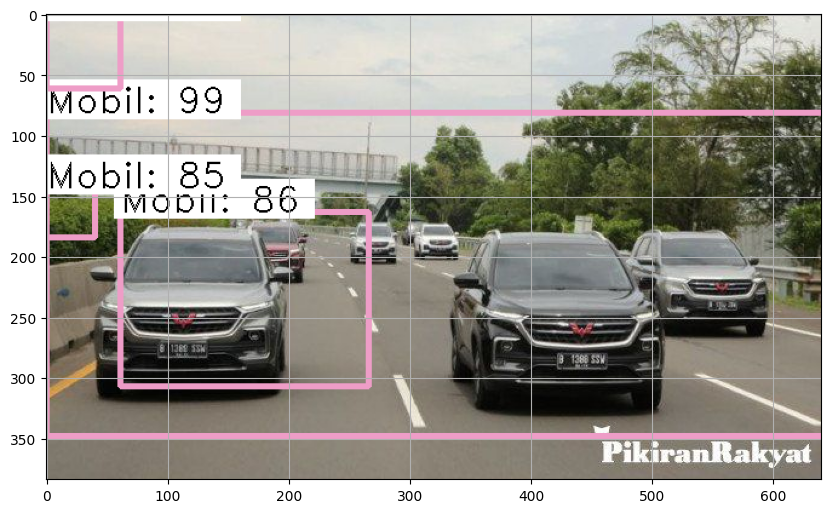

In [25]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.85

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, 'channels_last', overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

#### Measure mAP

In [27]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [28]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [29]:
print(class_mapping)

{0: 'Mobil', 1: 'bg'}


In [30]:
# This might takes a while to parser the data
test_imgs, classes_count, class_mapping = get_data(test_path)

Parsing annotation files
idx=5422

In [31]:
# Ambil class_mapping dari konfigurasi
class_mapping = C.class_mapping  

# Pastikan tidak ada kesalahan dalam struktur class_mapping
if isinstance(list(class_mapping.keys())[0], str):  # Jika key adalah string (nama kelas)
    class_mapping = {v: k for k, v in class_mapping.items()}  # Balikkan key dan value

# Debugging untuk memastikan pembalikan berhasil
print("Fixed class_mapping:", class_mapping)

# Membuat warna acak untuk setiap kelas
class_to_color = {v: np.random.randint(0, 255, 3) for v in class_mapping}


Fixed class_mapping: {0: 'Mobil', 1: 'bg'}


In [33]:
T = {}
P = {}
mAPs = []
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, 'channels_last', overlap_thresh=0.)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    #print(T)
    #print(P)
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/1018
Elapsed time = 2.9324707984924316
Mobil AP: 0.8
mAP = 0.8
1/1018
Elapsed time = 3.21604061126709
Mobil AP: 0.7
mAP = 0.7
2/1018
Elapsed time = 3.4591293334960938
Mobil AP: 0.5714285714285714
mAP = 0.5714285714285714
3/1018
Elapsed time = 3.396911382675171
Mobil AP: 0.6470588235294118
mAP = 0.6470588235294118
4/1018
Elapsed time = 3.2956948280334473
Mobil AP: 0.7
mAP = 0.7
5/1018
Elapsed time = 3.1763856410980225
Mobil AP: 0.7142857142857143
mAP = 0.7142857142857143
6/1018
Elapsed time = 3.2787249088287354
Mobil AP: 0.7380952380952381
mAP = 0.7380952380952381
7/1018
Elapsed time = 3.1322622299194336
Mobil AP: 0.76
mAP = 0.76
8/1018
Elapsed time = 3.074094295501709
Mobil AP: 0.7894736842105263
mAP = 0.7894736842105263
9/1018
Elapsed time = 4.123613119125366
Mobil AP: 0.7966101694915254
mAP = 0.7966101694915254
10/1018
Elapsed time = 4.700784206390381
Mobil AP: 0.8202912389591788
mAP = 0.8202912389591788
11/1018
Elapsed time = 4.117886543273926
Mobil AP: 0.8363636363636364
mAP = 0.

Elapsed time = 3.2392091751098633
Mobil AP: 0.8542540022216707
mAP = 0.8542540022216707
89/1018
Elapsed time = 3.1264946460723877
Mobil AP: 0.8537772168336349
mAP = 0.8537772168336349
90/1018
Elapsed time = 3.3179893493652344
Mobil AP: 0.8530575550485413
mAP = 0.8530575550485413
91/1018
Elapsed time = 3.156511068344116
Mobil AP: 0.8531035942164994
mAP = 0.8531035942164994
92/1018
Elapsed time = 3.2160115242004395
Mobil AP: 0.8530192651790742
mAP = 0.8530192651790742
93/1018
Elapsed time = 3.1494803428649902
Mobil AP: 0.8540107684888087
mAP = 0.8540107684888087
94/1018
Elapsed time = 3.145817279815674
Mobil AP: 0.8530678499927667
mAP = 0.8530678499927667
95/1018
Elapsed time = 3.027092695236206
Mobil AP: 0.8535592924281061
mAP = 0.8535592924281061
96/1018
Elapsed time = 3.481688976287842
Mobil AP: 0.8512066184636795
mAP = 0.8512066184636795
97/1018
Elapsed time = 3.2569632530212402
Mobil AP: 0.851699336043816
mAP = 0.851699336043816
98/1018
Elapsed time = 3.192950963973999
Mobil AP: 0.8

Elapsed time = 3.313129425048828
Mobil AP: 0.8652854709952033
mAP = 0.8652854709952033
175/1018
Elapsed time = 3.4353575706481934
Mobil AP: 0.8658343635105253
mAP = 0.8658343635105253
176/1018
Elapsed time = 3.2869303226470947
Mobil AP: 0.8663788024562227
mAP = 0.8663788024562227
177/1018
Elapsed time = 3.4604713916778564
Mobil AP: 0.8658906032433135
mAP = 0.8658906032433135
178/1018
Elapsed time = 3.3982014656066895
Mobil AP: 0.8662318333531235
mAP = 0.8662318333531235
179/1018
Elapsed time = 3.379685640335083
Mobil AP: 0.8672938074265343
mAP = 0.8672938074265343
180/1018
Elapsed time = 3.6353867053985596
Mobil AP: 0.8679490229974641
mAP = 0.8679490229974641
181/1018
Elapsed time = 3.8866069316864014
Mobil AP: 0.867484009263486
mAP = 0.867484009263486
182/1018
Elapsed time = 3.6873457431793213
Mobil AP: 0.8676142217317325
mAP = 0.8676142217317325
183/1018
Elapsed time = 4.415448904037476
Mobil AP: 0.8681325232795821
mAP = 0.8681325232795821
184/1018
Elapsed time = 4.003979921340942
Mo

Elapsed time = 3.402137041091919
Mobil AP: 0.8703668687601255
mAP = 0.8703668687601255
261/1018
Elapsed time = 3.300893545150757
Mobil AP: 0.8703060166121648
mAP = 0.8703060166121648
262/1018
Elapsed time = 3.3856828212738037
Mobil AP: 0.8681097295181976
mAP = 0.8681097295181976
263/1018
Elapsed time = 3.0847084522247314
Mobil AP: 0.8673201378891181
mAP = 0.8673201378891181
264/1018
Elapsed time = 2.8962061405181885
Mobil AP: 0.8679236293138258
mAP = 0.8679236293138258
265/1018
Elapsed time = 3.1279919147491455
Mobil AP: 0.8688609608182948
mAP = 0.8688609608182948
266/1018
Elapsed time = 3.287109851837158
Mobil AP: 0.867911198921805
mAP = 0.867911198921805
267/1018
Elapsed time = 3.465463876724243
Mobil AP: 0.8684192409607361
mAP = 0.8684192409607361
268/1018
Elapsed time = 3.259697914123535
Mobil AP: 0.8676836314272212
mAP = 0.8676836314272212
269/1018
Elapsed time = 3.223155975341797
Mobil AP: 0.8681861063677377
mAP = 0.8681861063677377
270/1018
Elapsed time = 3.099499464035034
Mobil

Elapsed time = 3.0963046550750732
Mobil AP: 0.8719692698040313
mAP = 0.8719692698040313
347/1018
Elapsed time = 3.302316188812256
Mobil AP: 0.8721735768632339
mAP = 0.8721735768632339
348/1018
Elapsed time = 3.2356319427490234
Mobil AP: 0.8719295594111771
mAP = 0.8719295594111771
349/1018
Elapsed time = 3.3432371616363525
Mobil AP: 0.8710715452397456
mAP = 0.8710715452397456
350/1018
Elapsed time = 3.427487373352051
Mobil AP: 0.8713910434760328
mAP = 0.8713910434760328
351/1018
Elapsed time = 3.3116629123687744
Mobil AP: 0.8718356900508618
mAP = 0.8718356900508618
352/1018
Elapsed time = 3.2572567462921143
Mobil AP: 0.8714671021502891
mAP = 0.8714671021502891
353/1018
Elapsed time = 3.320178508758545
Mobil AP: 0.8720981966915947
mAP = 0.8720981966915947
354/1018
Elapsed time = 3.2978291511535645
Mobil AP: 0.8710026065159402
mAP = 0.8710026065159402
355/1018
Elapsed time = 3.280134439468384
Mobil AP: 0.8713804065750859
mAP = 0.8713804065750859
356/1018
Elapsed time = 3.383239984512329
M

Elapsed time = 2.8743860721588135
Mobil AP: 0.8774062552473648
mAP = 0.8774062552473648
433/1018
Elapsed time = 3.1553092002868652
Mobil AP: 0.8776509813848858
mAP = 0.8776509813848858
434/1018
Elapsed time = 3.126534938812256
Mobil AP: 0.8777973486566198
mAP = 0.8777973486566198
435/1018
Elapsed time = 3.2176711559295654
Mobil AP: 0.8775938284281085
mAP = 0.8775938284281085
436/1018
Elapsed time = 3.0400800704956055
Mobil AP: 0.8775855951080778
mAP = 0.8775855951080778
437/1018
Elapsed time = 3.221461772918701
Mobil AP: 0.878069501487179
mAP = 0.878069501487179
438/1018
Elapsed time = 3.306199550628662
Mobil AP: 0.8781176817983306
mAP = 0.8781176817983306
439/1018
Elapsed time = 2.9776337146759033
Mobil AP: 0.8787405787222483
mAP = 0.8787405787222483
440/1018
Elapsed time = 3.2732467651367188
Mobil AP: 0.8787882302699817
mAP = 0.8787882302699817
441/1018
Elapsed time = 3.075125217437744
Mobil AP: 0.879120745379855
mAP = 0.879120745379855
442/1018
Elapsed time = 3.196808338165283
Mobil

Elapsed time = 3.3500027656555176
Mobil AP: 0.876205316036185
mAP = 0.876205316036185
519/1018
Elapsed time = 3.2906196117401123
Mobil AP: 0.8759147923195658
mAP = 0.8759147923195658
520/1018
Elapsed time = 3.1079888343811035
Mobil AP: 0.8759119593331642
mAP = 0.8759119593331642
521/1018
Elapsed time = 3.090097427368164
Mobil AP: 0.8757068680166317
mAP = 0.8757068680166317
522/1018
Elapsed time = 3.307598829269409
Mobil AP: 0.8759072149089617
mAP = 0.8759072149089617
523/1018
Elapsed time = 3.14365553855896
Mobil AP: 0.876108746518554
mAP = 0.876108746518554
524/1018
Elapsed time = 3.2224042415618896
Mobil AP: 0.8761058159703873
mAP = 0.8761058159703873
525/1018
Elapsed time = 2.944042205810547
Mobil AP: 0.8764660035156112
mAP = 0.8764660035156112
526/1018
Elapsed time = 3.2382078170776367
Mobil AP: 0.876302809278423
mAP = 0.876302809278423
527/1018
Elapsed time = 3.2398488521575928
Mobil AP: 0.8761798720869592
mAP = 0.8761798720869592
528/1018
Elapsed time = 3.1751301288604736
Mobil A

Elapsed time = 3.0582680702209473
Mobil AP: 0.872416182981807
mAP = 0.872416182981807
605/1018
Elapsed time = 3.2777493000030518
Mobil AP: 0.8725244973322495
mAP = 0.8725244973322495
606/1018
Elapsed time = 3.119835138320923
Mobil AP: 0.872848339755802
mAP = 0.872848339755802
607/1018
Elapsed time = 3.256530523300171
Mobil AP: 0.8725715188119186
mAP = 0.8725715188119186
608/1018
Elapsed time = 3.1873021125793457
Mobil AP: 0.8726432547597253
mAP = 0.8726432547597253
609/1018
Elapsed time = 3.2402470111846924
Mobil AP: 0.8725053266544814
mAP = 0.8725053266544814
610/1018
Elapsed time = 3.332777738571167
Mobil AP: 0.87272004191496
mAP = 0.87272004191496
611/1018
Elapsed time = 3.1431357860565186
Mobil AP: 0.8726537865735222
mAP = 0.8726537865735222
612/1018
Elapsed time = 3.193505048751831
Mobil AP: 0.8728675318902225
mAP = 0.8728675318902225
613/1018
Elapsed time = 3.283477783203125
Mobil AP: 0.8731514120193279
mAP = 0.8731514120193279
614/1018
Elapsed time = 3.2574198246002197
Mobil AP:

Elapsed time = 3.0630955696105957
Mobil AP: 0.8710824986672556
mAP = 0.8710824986672556
691/1018
Elapsed time = 3.3904337882995605
Mobil AP: 0.8712474838143955
mAP = 0.8712474838143955
692/1018
Elapsed time = 3.2877397537231445
Mobil AP: 0.8710420913704167
mAP = 0.8710420913704167
693/1018
Elapsed time = 3.2249338626861572
Mobil AP: 0.8711989474036927
mAP = 0.8711989474036927
694/1018
Elapsed time = 3.2583885192871094
Mobil AP: 0.8714803288091922
mAP = 0.8714803288091922
695/1018
Elapsed time = 3.1164965629577637
Mobil AP: 0.8711586182457015
mAP = 0.8711586182457015
696/1018
Elapsed time = 3.209120273590088
Mobil AP: 0.8712209401099344
mAP = 0.8712209401099344
697/1018
Elapsed time = 3.235881805419922
Mobil AP: 0.8714385926540965
mAP = 0.8714385926540965
698/1018
Elapsed time = 3.1404147148132324
Mobil AP: 0.8714764229150144
mAP = 0.8714764229150144
699/1018
Elapsed time = 3.174609422683716
Mobil AP: 0.8715247613665881
mAP = 0.8715247613665881
700/1018
Elapsed time = 3.1478374004364014

Elapsed time = 3.2061970233917236
Mobil AP: 0.870091259873159
mAP = 0.870091259873159
777/1018
Elapsed time = 3.3431684970855713
Mobil AP: 0.869100813831765
mAP = 0.869100813831765
778/1018
Elapsed time = 3.3194401264190674
Mobil AP: 0.869214125087348
mAP = 0.869214125087348
779/1018
Elapsed time = 3.076026678085327
Mobil AP: 0.8693554885944681
mAP = 0.8693554885944681
780/1018
Elapsed time = 3.250720262527466
Mobil AP: 0.8692340786613528
mAP = 0.8692340786613528
781/1018
Elapsed time = 3.2903244495391846
Mobil AP: 0.8690748621127603
mAP = 0.8690748621127603
782/1018
Elapsed time = 2.99149751663208
Mobil AP: 0.8695529095803859
mAP = 0.8695529095803859
783/1018
Elapsed time = 3.157405138015747
Mobil AP: 0.8696181395691767
mAP = 0.8696181395691767
784/1018
Elapsed time = 3.4374165534973145
Mobil AP: 0.8696740031016704
mAP = 0.8696740031016704
785/1018
Elapsed time = 3.228130340576172
Mobil AP: 0.8699526042585806
mAP = 0.8699526042585806
786/1018
Elapsed time = 3.076465606689453
Mobil AP:

Elapsed time = 3.5284650325775146
Mobil AP: 0.8726062311631265
mAP = 0.8726062311631265
863/1018
Elapsed time = 3.416165590286255
Mobil AP: 0.872515736024593
mAP = 0.872515736024593
864/1018
Elapsed time = 3.219900131225586
Mobil AP: 0.8720871875878102
mAP = 0.8720871875878102
865/1018
Elapsed time = 3.210336208343506
Mobil AP: 0.872384754718452
mAP = 0.872384754718452
866/1018
Elapsed time = 3.4940199851989746
Mobil AP: 0.8723637993820278
mAP = 0.8723637993820278
867/1018
Elapsed time = 3.3556089401245117
Mobil AP: 0.8726103803163068
mAP = 0.8726103803163068
868/1018
Elapsed time = 3.780996322631836
Mobil AP: 0.8729002839855714
mAP = 0.8729002839855714
869/1018
Elapsed time = 3.0799479484558105
Mobil AP: 0.8730206881306685
mAP = 0.8730206881306685
870/1018
Elapsed time = 3.4649293422698975
Mobil AP: 0.873068785940384
mAP = 0.873068785940384
871/1018
Elapsed time = 3.4408559799194336
Mobil AP: 0.8732128609993229
mAP = 0.8732128609993229
872/1018
Elapsed time = 3.1718029975891113
Mobil 

Elapsed time = 3.398782730102539
Mobil AP: 0.8718945118800624
mAP = 0.8718945118800624
949/1018
Elapsed time = 3.217247247695923
Mobil AP: 0.8717650658205391
mAP = 0.8717650658205391
950/1018
Elapsed time = 3.277848958969116
Mobil AP: 0.8718096813113215
mAP = 0.8718096813113215
951/1018
Elapsed time = 3.484020471572876
Mobil AP: 0.8717472391195866
mAP = 0.8717472391195866
952/1018
Elapsed time = 3.2585668563842773
Mobil AP: 0.87176952670361
mAP = 0.87176952670361
953/1018
Elapsed time = 3.1819965839385986
Mobil AP: 0.872080741531224
mAP = 0.872080741531224
954/1018
Elapsed time = 3.310930013656616
Mobil AP: 0.8724345710465058
mAP = 0.8724345710465058
955/1018
Elapsed time = 3.2309892177581787
Mobil AP: 0.8720264895249648
mAP = 0.8720264895249648
956/1018
Elapsed time = 3.323566198348999
Mobil AP: 0.8717690819857369
mAP = 0.8717690819857369
957/1018
Elapsed time = 3.128286123275757
Mobil AP: 0.8716232389330809
mAP = 0.8716232389330809
958/1018
Elapsed time = 3.2970950603485107
Mobil AP:

In [34]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision is %0.3f'%(len(record_df), mean_average_prec))

# record_df.loc[len(record_df)-1, 'mAP'] = mean_average_prec
# record_df.to_csv(C.record_path, index=0)
# print('Save mAP to {}'.format(C.record_path))

After training 400k batches, the mean average precision is 0.869


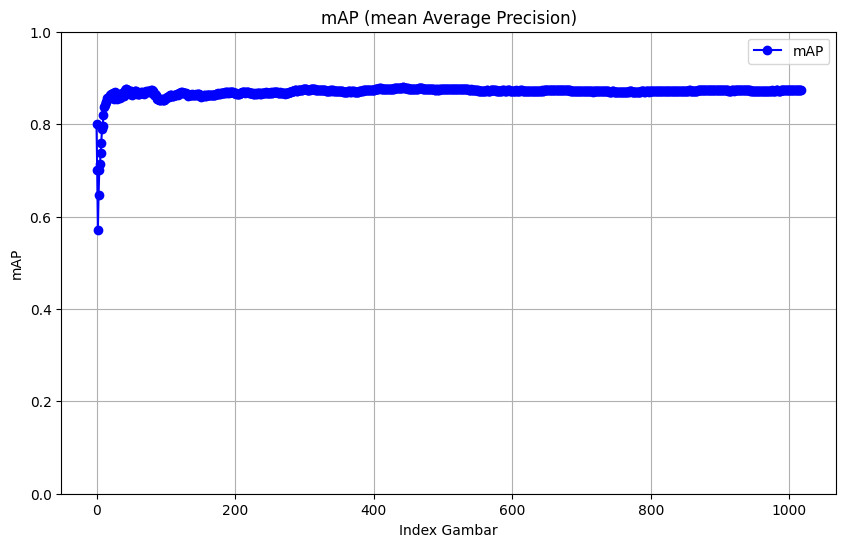

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mAPs, marker='o', linestyle='-', color='blue', label='mAP')
plt.title('mAP (mean Average Precision)')
plt.xlabel('Index Gambar')
plt.ylabel('mAP')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


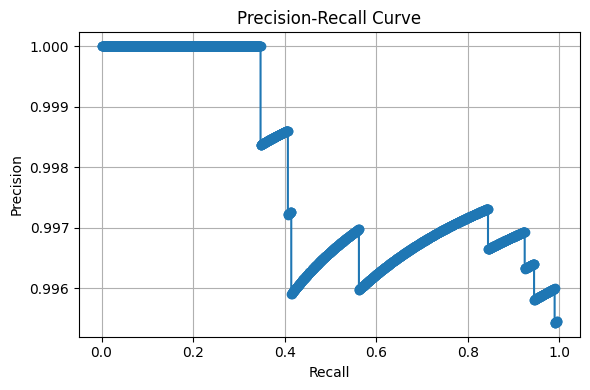

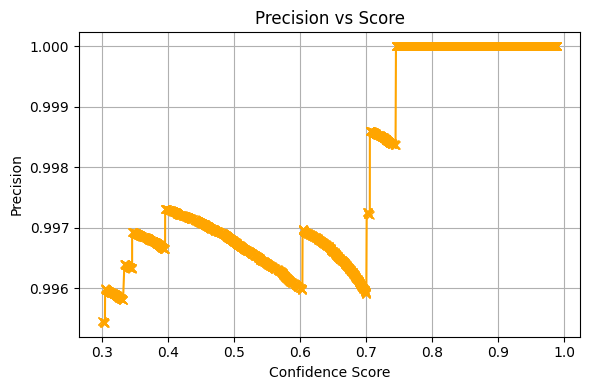

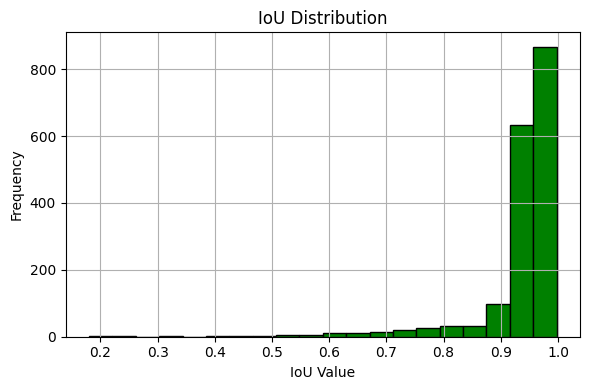

In [39]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# === Path dasar folder data ===
BASE_PATH = "C:/Users/Lenovo/Documents/TA-2025-01"
GROUND_TRUTH_FILE = os.path.join(BASE_PATH, "train annotation_normalized4.txt")

def load_ground_truth(filepath):
    gt = defaultdict(list)
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split(',')
            filename = parts[0].split('/')[-1]
            box = list(map(int, parts[1:5]))
            gt[filename].append(box)
    return gt



# === Precision, Recall, dan IoU ===
def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    all_scores = []
    all_matches = []
    all_ious = []

    for filename in pred_boxes:
        gt = gt_boxes.get(filename, [])
        preds = pred_boxes[filename]
        preds = sorted(preds, key=lambda x: x[1], reverse=True)
        matched_gt = [False] * len(gt)

        for pred_box, score in preds:
            max_iou = 0
            max_i = -1
            for i, gt_box in enumerate(gt):
                iou_val = iou(pred_box, gt_box)
                if iou_val > max_iou and not matched_gt[i]:
                    max_iou = iou_val
                    max_i = i

            all_ious.append(max_iou)
            if max_iou >= iou_threshold and max_i >= 0:
                matched_gt[max_i] = True
                all_scores.append(score)
                all_matches.append(1)
            else:
                all_scores.append(score)
                all_matches.append(0)

    sorted_idx = np.argsort(-np.array(all_scores))
    tp = np.array(all_matches)[sorted_idx]
    fp = 1 - tp
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    precision = cum_tp / (cum_tp + cum_fp + 1e-6)
    recall = cum_tp / (len([g for v in gt_boxes.values() for g in v]) + 1e-6)

    return precision, recall, np.array(all_scores)[sorted_idx], np.array(all_ious)

# === Plot ===
def plot_precision_recall_curve(precision, recall):
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='o')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_precision_vs_score(precision, scores):
    plt.figure(figsize=(6, 4))
    plt.plot(scores, precision, marker='x', color='orange')
    plt.xlabel("Confidence Score")
    plt.ylabel("Precision")
    plt.title("Precision vs Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_iou_distribution(ious):
    plt.figure(figsize=(6, 4))
    plt.hist(ious, bins=20, color='green', edgecolor='black')
    plt.xlabel("IoU Value")
    plt.ylabel("Frequency")
    plt.title("IoU Distribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Main ===
if __name__ == "__main__":
    gt_boxes = load_ground_truth(GROUND_TRUTH_FILE)
    pred_boxes = generate_dummy_predictions(gt_boxes)
    precision, recall, scores, ious = compute_precision_recall(gt_boxes, pred_boxes)

    # Plot 3 grafik terpisah
    plot_precision_recall_curve(precision, recall)
    plot_precision_vs_score(precision, scores)
    plot_iou_distribution(ious)
